# Grad-CAM + MC-GradCAM para CNN con Incertidumbre

Visualización de explicabilidad para el modelo UncertaintyCNN.

## Técnicas implementadas:
1. **Grad-CAM**: Mapas de activación basados en gradientes
2. **MC-GradCAM**: Incertidumbre epistémica en explicaciones (mean + std)

## Análisis:
- Batch del test set (verificar patrones por clase)
- Casos manuales (archivos específicos)

## Requisitos:
- Ejecutar primero `cnn_uncertainty_training.ipynb` para generar el modelo y config
- Archivo `results/cnn_uncertainty/gradcam_config.json` debe existir


## 1. Setup e Imports


In [1]:
import sys
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.model_selection import train_test_split

# Agregar módulos propios al path
sys.path.insert(0, str(Path.cwd()))

# Importar módulos propios
from modules.models.uncertainty.model import UncertaintyCNN, MCDropout2d, MCDropout
from modules.core.dataset import load_spectrograms_cache, to_pytorch_tensors

# Configuración de matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configuración de PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("="*70)
print("🎯 GRAD-CAM + MC-GRADCAM PARA CNN CON INCERTIDUMBRE")
print("="*70)
print(f"✅ Librerías cargadas correctamente")
print(f"🔧 Dispositivo: {device}")
print(f"📦 PyTorch: {torch.__version__}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
print("="*70)


🎯 GRAD-CAM + MC-GRADCAM PARA CNN CON INCERTIDUMBRE
✅ Librerías cargadas correctamente
🔧 Dispositivo: cpu
📦 PyTorch: 2.8.0+cpu


## 2. Clase GradCAM


In [2]:
class GradCAM:
    """Grad-CAM para modelos con dos salidas (logits, s_logit)."""
    
    def __init__(self, model, target_layer_name):
        self.model = model.eval()
        self._activations = None
        self._gradients = None
        
        # Localizar capa por nombre (ej: "block2.2")
        layer = dict(model.named_modules())[target_layer_name]
        layer.register_forward_hook(self._hook_forward)
        layer.register_full_backward_hook(self._hook_backward)
    
    def _hook_forward(self, module, input, output):
        self._activations = output.detach()
    
    def _hook_backward(self, module, grad_in, grad_out):
        self._gradients = grad_out[0].detach()
    
    def __call__(self, x, class_idx, enable_dropout=False):
        """
        Genera Grad-CAM para una clase específica.
        
        Args:
            x: Input [B, 1, H, W]
            class_idx: Índice de clase objetivo
            enable_dropout: Si True, activa MC dropout
        
        Returns:
            cam: [B, H_out, W_out] normalized
        """
        if enable_dropout:
            self._enable_mc_dropout(True)
        
        self.model.zero_grad()
        logits, s_logit = self.model(x)
        
        # Backward en logits[class_idx]
        logits[:, class_idx].sum().backward(retain_graph=True)
        
        # Grad-CAM: w = GAP(gradients), cam = ReLU(w * activations)
        weights = self._gradients.mean(dim=(2, 3), keepdim=True)  # [B, C, 1, 1]
        cam = (weights * self._activations).sum(dim=1)  # [B, H, W]
        cam = F.relu(cam)
        
        # Normalizar [0,1]
        cam = cam.unsqueeze(1)  # [B, 1, H, W]
        cam = F.interpolate(cam, size=x.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze(1)  # [B, H, W]
        
        # Normalizar por muestra
        for i in range(cam.shape[0]):
            cam_min = cam[i].min()
            cam_max = cam[i].max()
            if cam_max > cam_min:
                cam[i] = (cam[i] - cam_min) / (cam_max - cam_min + 1e-8)
        
        return cam
    
    def mc_gradcam(self, x, class_idx, n_samples=30):
        """MC-GradCAM: múltiples pasadas con dropout."""
        self._enable_mc_dropout(True)
        cams = []
        
        for _ in range(n_samples):
            cam = self(x, class_idx, enable_dropout=True)
            cams.append(cam)
        
        cams = torch.stack(cams)  # [T, B, H, W]
        cam_mean = cams.mean(dim=0)  # [B, H, W]
        cam_std = cams.std(dim=0)    # [B, H, W]
        
        return cam_mean, cam_std
    
    def _enable_mc_dropout(self, enabled):
        """Activa/desactiva dropout para MC."""
        for m in self.model.modules():
            if isinstance(m, (MCDropout, MCDropout2d)):
                m.train(enabled)

print("✅ Clase GradCAM definida")


✅ Clase GradCAM definida


## 3. Cargar Modelo y Configuración


In [5]:
# Cargar configuración
save_dir = Path("./results/cnn_uncertainty")
config_path = save_dir / "gradcam_config.json"

if not config_path.exists():
    raise FileNotFoundError(f"No se encontró el archivo de configuración: {config_path}")

with open(config_path, "r") as f:
    config = json.load(f)

print("="*70)
print("CONFIGURACIÓN CARGADA")
print("="*70)
print(f"Target layer: {config['target_layer']}")
print(f"Classes: {config['class_names']}")
print(f"MC samples: {config['bayesian']['mc_samples_default']}")
print(f"Input size: {config['preprocess']['input_size']}")

# Reconstruir modelo
model = UncertaintyCNN(**config["model_params"]).to(device)

# Cargar pesos
weights_path = save_dir / "best_model_uncertainty.pth"
if not weights_path.exists():
    raise FileNotFoundError(f"No se encontró el modelo entrenado: {weights_path}")

model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()

print(f"Modelo cargado: {weights_path}")

# Crear GradCAM
gradcam = GradCAM(model, config["target_layer"])
print(f"GradCAM inicializado en capa: {config['target_layer']}")
print("="*70)


CONFIGURACIÓN CARGADA
Target layer: block2.2
Classes: ['Healthy', 'Parkinson']
MC samples: 30
Input size: [1, 65, 41]
Modelo cargado: results\cnn_uncertainty\best_model_uncertainty.pth
GradCAM inicializado en capa: block2.2


## 4. Funciones de Visualización


In [6]:
def plot_gradcam_overlay(spectrogram, cam, title, save_path=None):
    """Superpone Grad-CAM sobre espectrograma."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Original
    axes[0].imshow(spectrogram.squeeze(), aspect='auto', cmap='viridis')
    axes[0].set_title('Espectrograma Original')
    axes[0].axis('off')
    
    # Grad-CAM
    axes[1].imshow(cam, aspect='auto', cmap='jet')
    axes[1].set_title('Grad-CAM')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(spectrogram.squeeze(), aspect='auto', cmap='gray', alpha=0.7)
    axes[2].imshow(cam, aspect='auto', cmap='jet', alpha=0.4)
    axes[2].set_title('Overlay')
    axes[2].axis('off')
    
    fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        print(f"Guardado: {save_path}")
    
    plt.show()
    return fig

def plot_mc_gradcam(spectrogram, cam_mean, cam_std, title, save_path=None):
    """Visualiza MC-GradCAM con mean y std."""
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    
    # Original
    axes[0].imshow(spectrogram.squeeze(), aspect='auto', cmap='viridis')
    axes[0].set_title('Espectrograma')
    axes[0].axis('off')
    
    # CAM mean
    axes[1].imshow(cam_mean, aspect='auto', cmap='jet')
    axes[1].set_title('CAM Mean')
    axes[1].axis('off')
    
    # CAM std (incertidumbre)
    im_std = axes[2].imshow(cam_std, aspect='auto', cmap='plasma')
    axes[2].set_title('CAM Std (Incertidumbre)')
    axes[2].axis('off')
    plt.colorbar(im_std, ax=axes[2], fraction=0.046)
    
    # Overlay
    axes[3].imshow(spectrogram.squeeze(), aspect='auto', cmap='gray', alpha=0.7)
    axes[3].imshow(cam_mean, aspect='auto', cmap='jet', alpha=0.4)
    axes[3].set_title('Overlay Mean')
    axes[3].axis('off')
    
    fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        print(f"Guardado: {save_path}")
    
    plt.show()
    return fig

print("✅ Funciones de visualización definidas")


✅ Funciones de visualización definidas


## 5. Cargar Test Set


In [7]:
# Cargar datos
CACHE_HEALTHY = "./cache/original/healthy_ibarra.pkl"
CACHE_PARKINSON = "./cache/augmented/augmented_dataset_specaugment.pkl"

print("="*70)
print("CARGANDO DATOS PARA ANÁLISIS")
print("="*70)

healthy_dataset = load_spectrograms_cache(CACHE_HEALTHY)
parkinson_dataset = load_spectrograms_cache(CACHE_PARKINSON)

X_healthy, y_h, _, _ = to_pytorch_tensors(healthy_dataset)
X_parkinson, y_p, _, _ = to_pytorch_tensors(parkinson_dataset)

X_combined = torch.cat([X_healthy, X_parkinson], dim=0)
y_combined = torch.cat([torch.zeros(len(X_healthy), dtype=torch.long),
                        torch.ones(len(X_parkinson), dtype=torch.long)])

# Reproducir split (mismo seed)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_combined, y_combined, test_size=0.15, random_state=42, stratify=y_combined
)

print(f"Test set: {len(X_test)} muestras")
print(f"  Healthy: {(y_test==0).sum().item()}")
print(f"  Parkinson: {(y_test==1).sum().item()}")

# Seleccionar ejemplos (2 de cada clase)
idx_healthy = torch.where(y_test == 0)[0][:2]
idx_parkinson = torch.where(y_test == 1)[0][:2]
idx_samples = torch.cat([idx_healthy, idx_parkinson])

X_samples = X_test[idx_samples].to(device)
y_samples = y_test[idx_samples]

print(f"Muestras seleccionadas: {len(X_samples)}")
print(f"  Healthy: {len(idx_healthy)}")
print(f"  Parkinson: {len(idx_parkinson)}")
print("="*70)


CARGANDO DATOS PARA ANÁLISIS
Cache cargado: ./cache/original/healthy_ibarra.pkl
   Tamaño: 12.0 MB
   Muestras: 155
Cache cargado: ./cache/augmented/augmented_dataset_specaugment.pkl
   Tamaño: 11.9 MB
   Muestras: 363
PyTorch tensors listos:
  - X: (155, 1, 65, 41)
  - y_task: (155,)  (dist={0: 155})
  - y_domain: (155,)  (K dominios=13)
PyTorch tensors listos:
  - X: (363, 1, 65, 41)
  - y_task: (363,)  (dist={0: 363})
  - y_domain: (363,)  (K dominios=13)
Test set: 78 muestras
  Healthy: 23
  Parkinson: 55
Muestras seleccionadas: 4
  Healthy: 2
  Parkinson: 2


## 6. Grad-CAM Estándar en Test Set


GRAD-CAM ESTÁNDAR EN TEST SET
Guardado: results\cnn_uncertainty\gradcam_outputs\gradcam_test_1.png


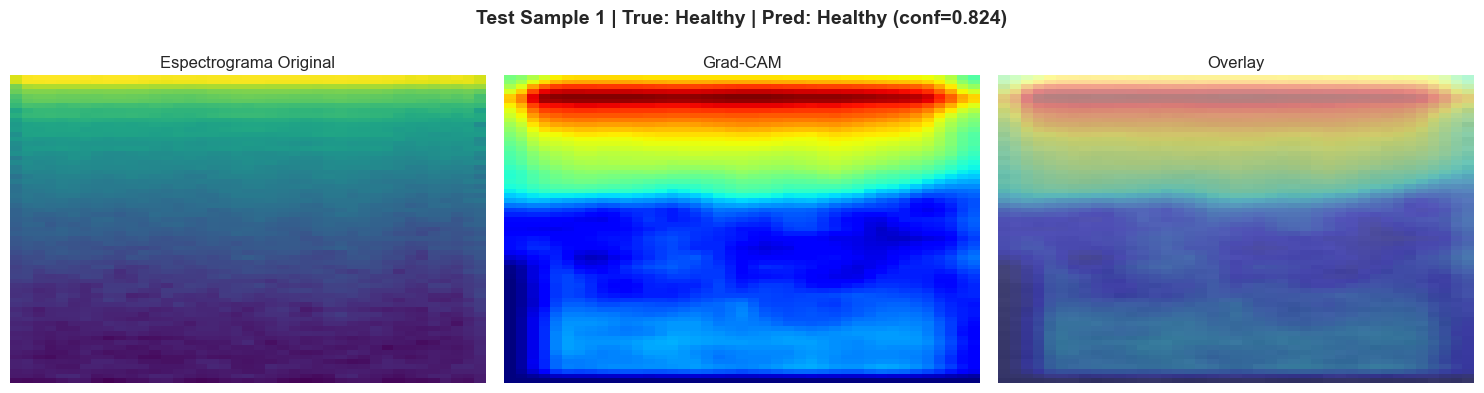

Guardado: results\cnn_uncertainty\gradcam_outputs\gradcam_test_2.png


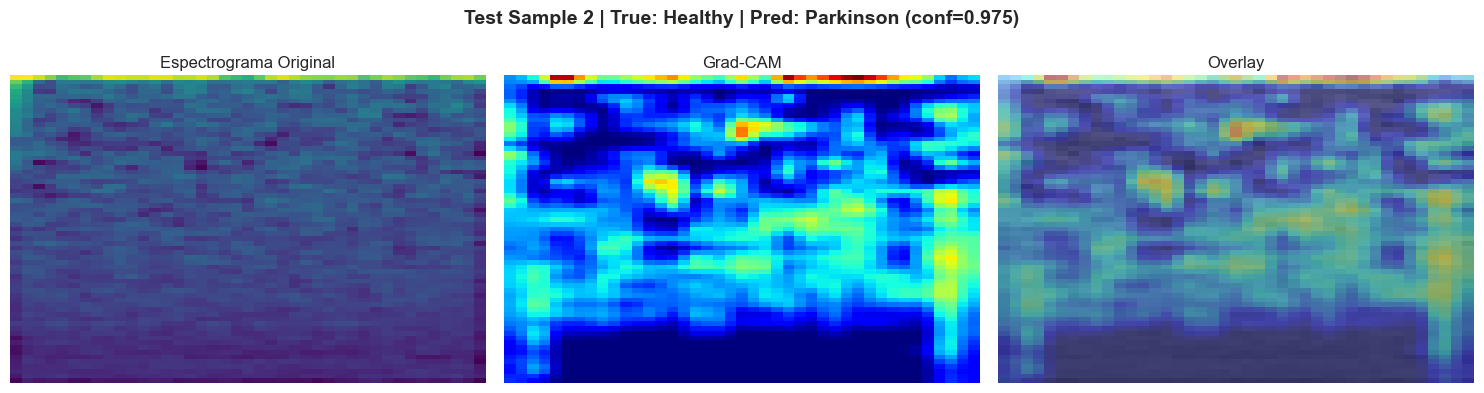

Guardado: results\cnn_uncertainty\gradcam_outputs\gradcam_test_3.png


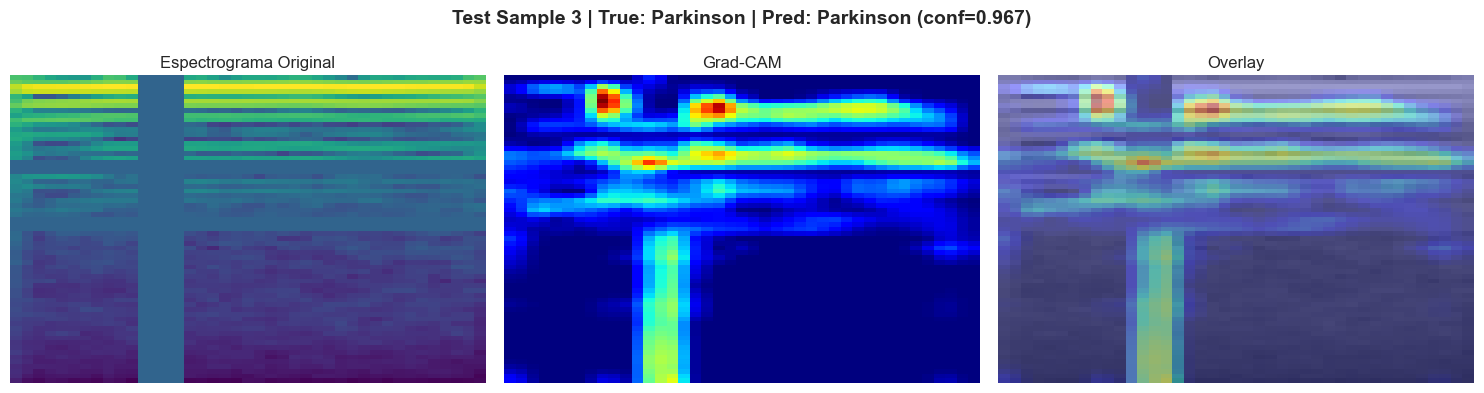

Guardado: results\cnn_uncertainty\gradcam_outputs\gradcam_test_4.png


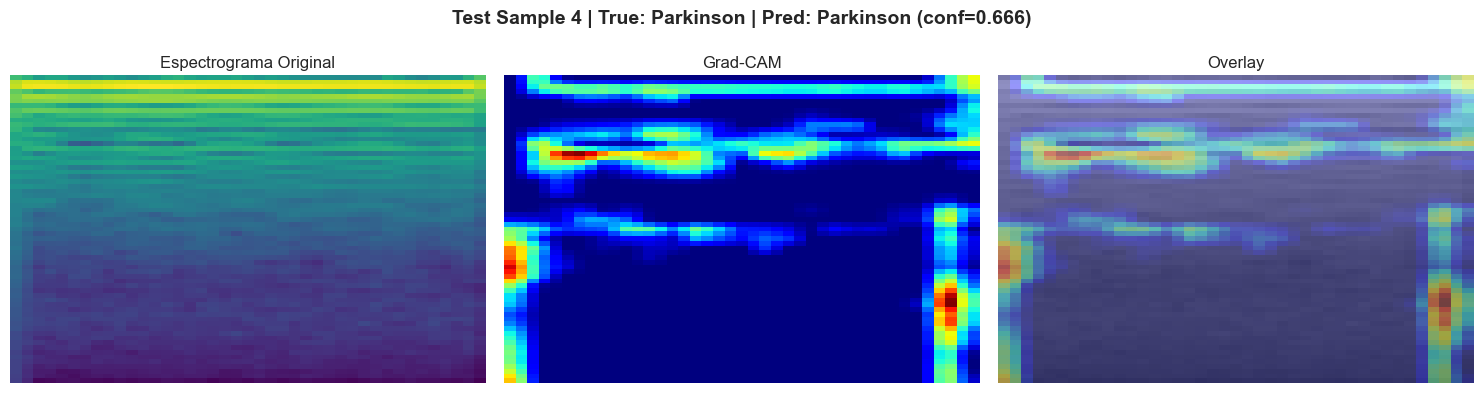

Grad-CAM guardados en: results\cnn_uncertainty\gradcam_outputs


In [8]:
print("="*70)
print("GRAD-CAM ESTÁNDAR EN TEST SET")
print("="*70)

output_dir = save_dir / "gradcam_outputs"
output_dir.mkdir(exist_ok=True)

for i, (x, y_true) in enumerate(zip(X_samples, y_samples)):
    x_input = x.unsqueeze(0).to(device)
    
    # Predicción
    with torch.no_grad():
        logits, s_logit = model(x_input)
        probs = F.softmax(logits, dim=1)[0]
        pred = probs.argmax().item()
        conf = probs.max().item()
    
    true_label = config["class_names"][y_true.item()]
    pred_label = config["class_names"][pred]
    
    # Grad-CAM para clase predicha
    cam = gradcam(x_input, class_idx=pred, enable_dropout=False)
    cam_np = cam[0].cpu().numpy()
    
    spec_np = x[0].cpu().numpy()
    
    title = (f"Test Sample {i+1} | True: {true_label} | "
             f"Pred: {pred_label} (conf={conf:.3f})")
    
    save_path = output_dir / f"gradcam_test_{i+1}.png"
    plot_gradcam_overlay(spec_np, cam_np, title, save_path)

print(f"Grad-CAM guardados en: {output_dir}")


## 7. MC-GradCAM en Test Set


MC-GRADCAM EN TEST SET
Generando MC-GradCAM para muestra 1 (T=30)...
Guardado: results\cnn_uncertainty\gradcam_outputs\mc_gradcam_test_1.png


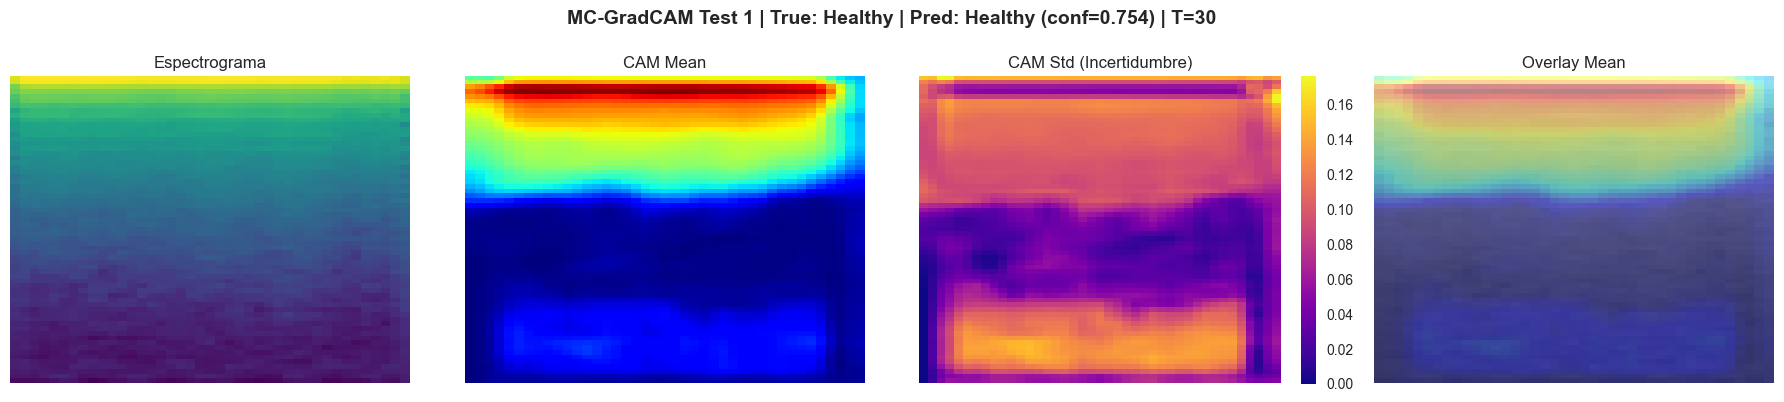

Generando MC-GradCAM para muestra 2 (T=30)...
Guardado: results\cnn_uncertainty\gradcam_outputs\mc_gradcam_test_2.png


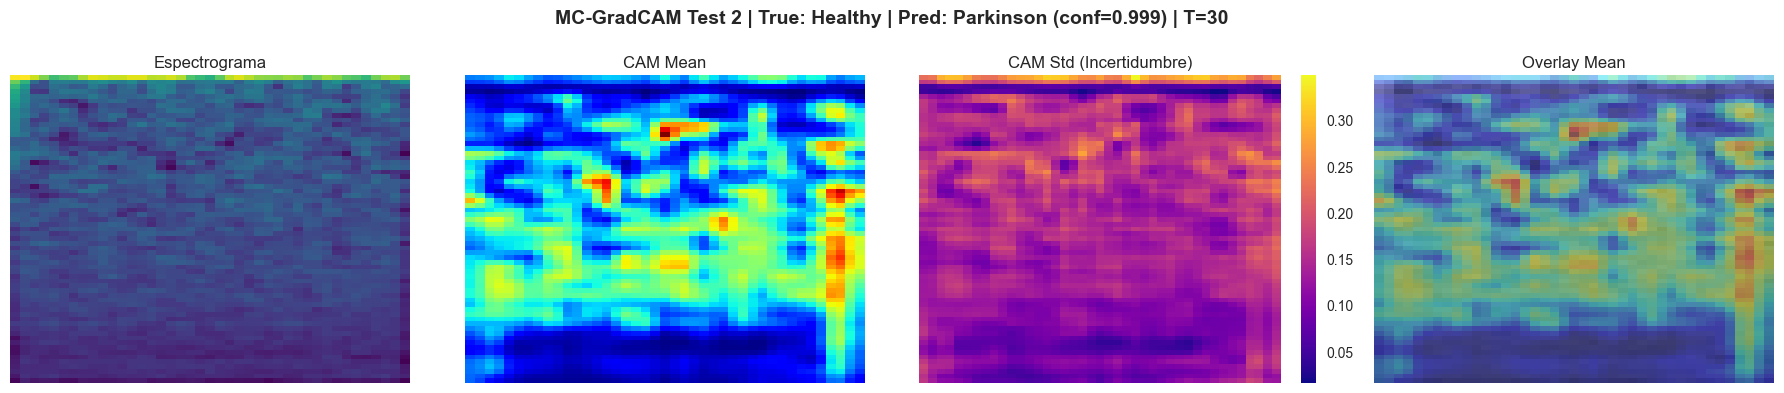

Generando MC-GradCAM para muestra 3 (T=30)...
Guardado: results\cnn_uncertainty\gradcam_outputs\mc_gradcam_test_3.png


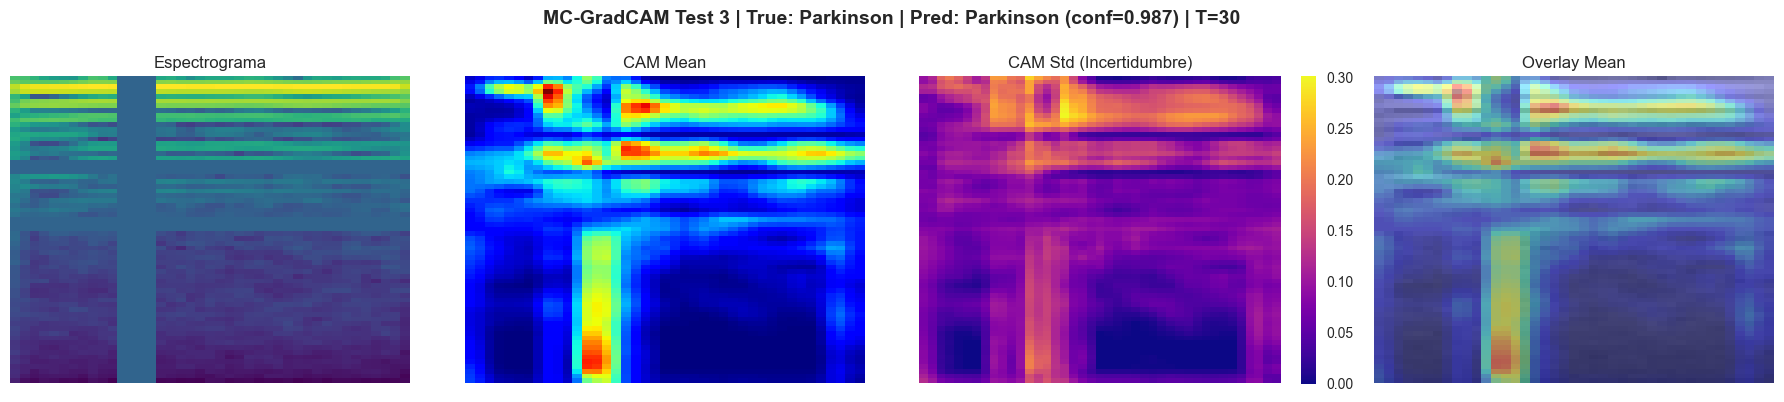

Generando MC-GradCAM para muestra 4 (T=30)...
Guardado: results\cnn_uncertainty\gradcam_outputs\mc_gradcam_test_4.png


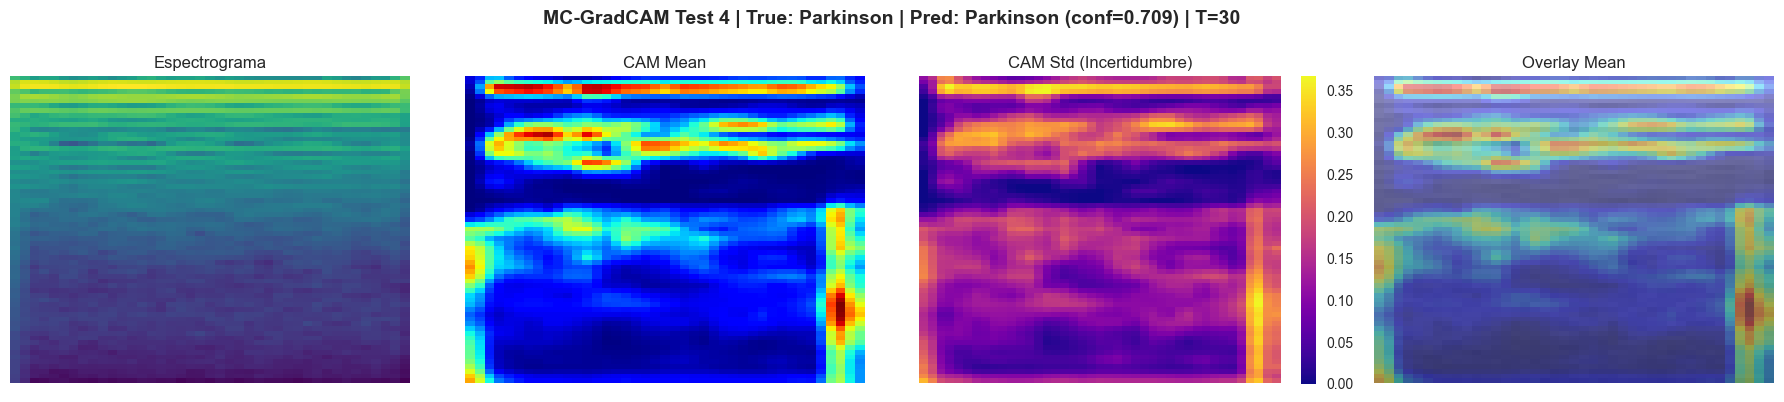

MC-GradCAM guardados en: results\cnn_uncertainty\gradcam_outputs


In [9]:
print("="*70)
print("MC-GRADCAM EN TEST SET")
print("="*70)

T_MC = config["bayesian"]["mc_samples_default"]

for i, (x, y_true) in enumerate(zip(X_samples, y_samples)):
    x_input = x.unsqueeze(0).to(device)
    
    # Predicción
    with torch.no_grad():
        logits, s_logit = model(x_input)
        probs = F.softmax(logits, dim=1)[0]
        pred = probs.argmax().item()
        conf = probs.max().item()
    
    true_label = config["class_names"][y_true.item()]
    pred_label = config["class_names"][pred]
    
    # MC-GradCAM
    print(f"Generando MC-GradCAM para muestra {i+1} (T={T_MC})...")
    cam_mean, cam_std = gradcam.mc_gradcam(x_input, class_idx=pred, n_samples=T_MC)
    
    cam_mean_np = cam_mean[0].cpu().numpy()
    cam_std_np = cam_std[0].cpu().numpy()
    spec_np = x[0].cpu().numpy()
    
    title = (f"MC-GradCAM Test {i+1} | True: {true_label} | "
             f"Pred: {pred_label} (conf={conf:.3f}) | T={T_MC}")
    
    save_path = output_dir / f"mc_gradcam_test_{i+1}.png"
    plot_mc_gradcam(spec_np, cam_mean_np, cam_std_np, title, save_path)

print(f"MC-GradCAM guardados en: {output_dir}")


## 8. Análisis de Casos Manuales

Para analizar un espectrograma específico:

1. Preprocesa el archivo `.egg` usando el pipeline de `data_preprocessing.ipynb`
2. Carga el espectrograma como tensor `[1, 1, 65, 41]`
3. Ejecuta las siguientes celdas con tu input


In [10]:
# EJEMPLO: Análisis manual de archivo específico
# Descomenta y ajusta según tu caso

# from modules.core.preprocessing import preprocess_egg_file

# # 1. Preprocesar archivo
# egg_path = "path/to/your/file.egg"  # AJUSTAR
# spec = preprocess_egg_file(egg_path)  # implementar según tu pipeline

# # 2. Convertir a tensor
# x_manual = torch.tensor(spec, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

# # 3. Predicción
# with torch.no_grad():
#     logits, s_logit = model(x_manual)
#     probs = F.softmax(logits, dim=1)[0]
#     pred = probs.argmax().item()
#     conf = probs.max().item()

# print(f"Predicción: {config['class_names'][pred]} (conf={conf:.3f})")

# # 4. Grad-CAM
# cam = gradcam(x_manual, class_idx=pred, enable_dropout=False)
# cam_np = cam[0].cpu().numpy()
# spec_np = x_manual[0, 0].cpu().numpy()

# plot_gradcam_overlay(spec_np, cam_np, f"Manual: {egg_path}", 
#                      save_path=output_dir / "gradcam_manual.png")

# # 5. MC-GradCAM
# cam_mean, cam_std = gradcam.mc_gradcam(x_manual, class_idx=pred, n_samples=T_MC)
# plot_mc_gradcam(spec_np, cam_mean[0].cpu().numpy(), cam_std[0].cpu().numpy(),
#                 f"MC-GradCAM Manual: {egg_path}",
#                 save_path=output_dir / "mc_gradcam_manual.png")

print("✅ Template para análisis manual disponible")
print("📝 Descomenta y ajusta el código según tu caso específico")


✅ Template para análisis manual disponible
📝 Descomenta y ajusta el código según tu caso específico


## 📋 Resumen Final

### ✅ Completado:
1. **Grad-CAM**: Mapas de activación para explicabilidad
2. **MC-GradCAM**: Incertidumbre epistémica en explicaciones
3. **Análisis**: Test set + casos manuales

### 🎯 Técnicas implementadas:
- **Target layer**: `block2.2` (ReLU después de la segunda convolución)
- **MC-Dropout**: Activado para generar incertidumbre en explicaciones
- **Visualización**: Overlay + mean/std de MC-GradCAM

### 📊 Archivos generados:
- `results/cnn_uncertainty/gradcam_outputs/gradcam_test_*.png`
- `results/cnn_uncertainty/gradcam_outputs/mc_gradcam_test_*.png`

### 🔬 Interpretación:
- **Grad-CAM**: Regiones importantes para la predicción
- **MC-GradCAM std**: Incertidumbre en las explicaciones (regiones inconsistentes)
